In [94]:
file = open("/home/mviswanathsai/Downloads/names.txt", "r")
words = file.read().splitlines()

In [95]:
import random
import torch # Just to ensure consistent results, use the PyTorch generator's seed

# 1. Set a manual seed for reproducibility
g = torch.Generator().manual_seed(2147483647)
# Use the Python random module, seeded from the PyTorch generator's state
random.seed(g.initial_seed()) # Seeds Python's random with the PyTorch seed

# 2. Shuffle the data
# Shuffling the list in-place ensures the splits are random and not sequential
random.shuffle(words)

# 3. Calculate split sizes
total_size = len(words)
train_size = int(0.8 * total_size)  # 80%
dev_size = int(0.1 * total_size)    # 10%
# The remaining 10% goes to the test set to account for potential floating point errors
test_size = total_size - train_size - dev_size

# 4. Perform the slicing
train_data = words[:train_size]
dev_data = words[train_size : train_size + dev_size]
test_data = words[train_size + dev_size :]

print(f"Total words: {total_size}")
print(f"Train set size (80%): {len(train_data)}")
print(f"Dev set size (10%): {len(dev_data)}")
print(f"Test set size (10%): {len(test_data)}")

Total words: 32033
Train set size (80%): 25626
Dev set size (10%): 3203
Test set size (10%): 3204


In [96]:
import torch 
N = torch.zeros((27,27), dtype = torch.int32)

In [97]:
alphabets = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(alphabets)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [98]:
# Train on the training data
for w in train_data:
    w = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(w, w[1:]):
        bigram = (ch1, ch2)
        row = stoi[ch1]
        column = stoi[ch2]
        N[row, column] += 1

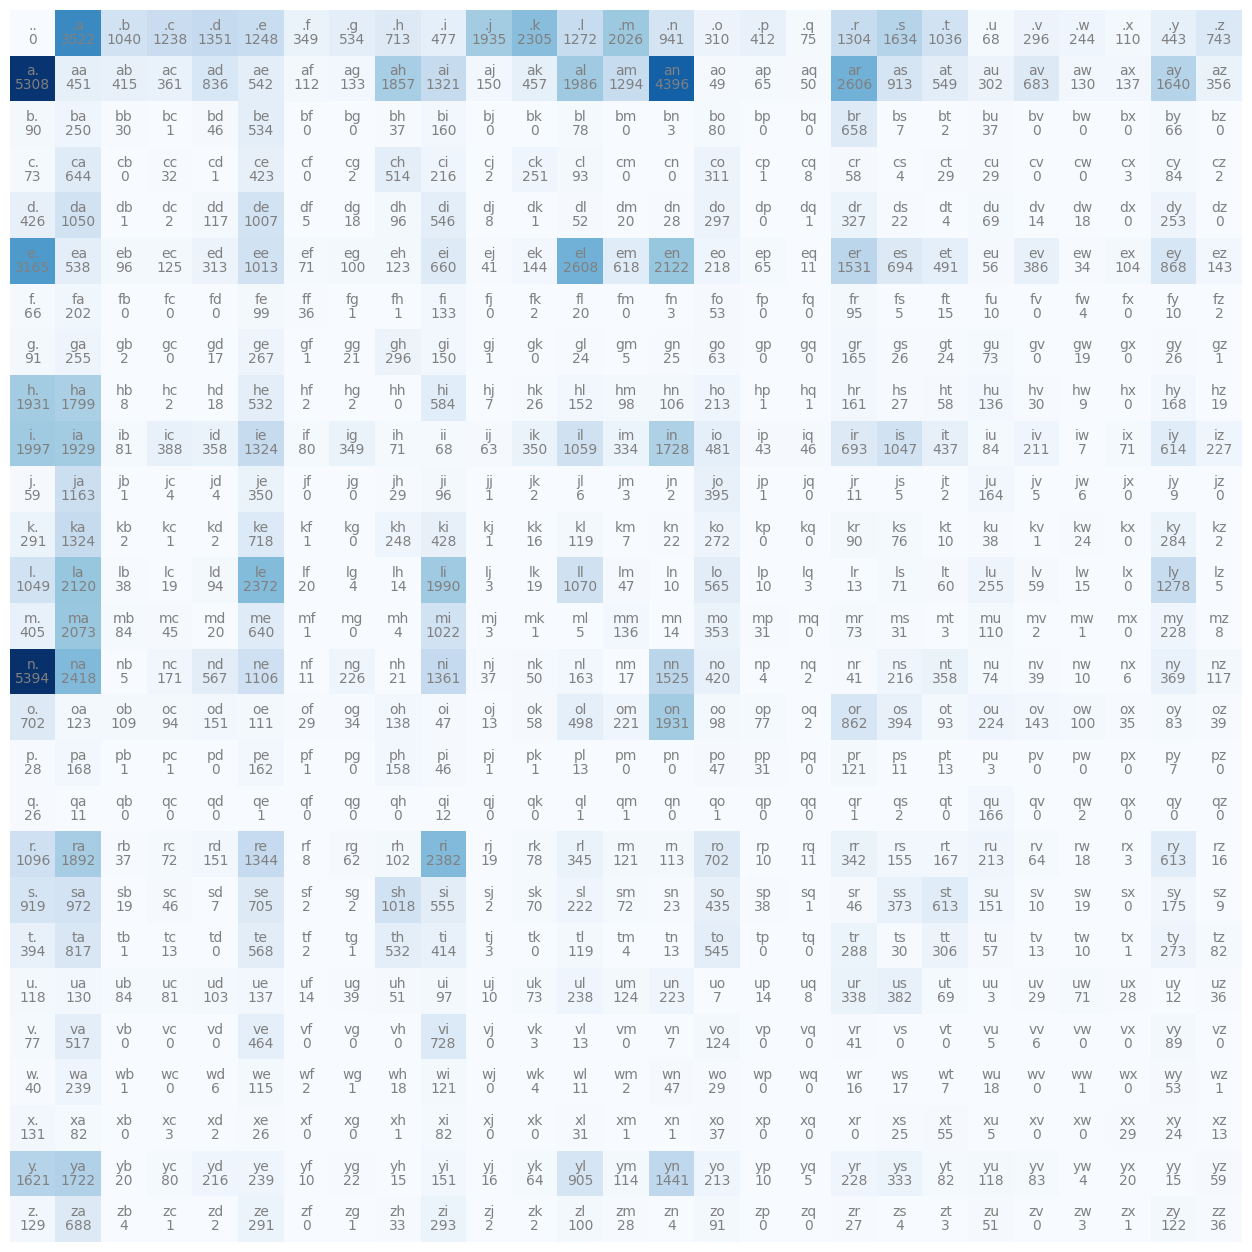

In [99]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[16,16])
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')

plt.axis('off');

In [100]:
P = (N+2).float()
P /= P.sum(1, keepdim=True)

In [101]:
g = torch.Generator().manual_seed(2147483647)
output = ""

for i in range(10):
    out = []
    ix = 0
    while True:
        ix = torch.multinomial(P[ix], num_samples = 1, replacement = True, generator = g).item()
        out.append(itos[ix])
        if ix == 0: 
            break
    print(''.join(out))


cexze.
momasurailezitynn.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.


In [102]:
# Validate on the dev data to figure out best hyper parameters
for k in range(10): 
    print(f'{k}')
    P = (N+k).float()
    P /= P.sum(1, keepdim=True)

    n = 0
    log_likelihood = 0
    for w in dev_data:
        for ch1, ch2 in zip(w, w[1:]):
            bigram = (ch1, ch2)
            prob = P[stoi[ch1], stoi[ch2]]
            logprob = torch.log(prob)
            log_likelihood += logprob
            n += 1
    
    print(f'{log_likelihood=}')   
    print('negative_loglikelihood=', -log_likelihood)
    print('avg_nll=', -log_likelihood/n)

0
log_likelihood=tensor(-inf)
negative_loglikelihood= tensor(inf)
avg_nll= tensor(inf)
1
log_likelihood=tensor(-41331.9023)
negative_loglikelihood= tensor(41331.9023)
avg_nll= tensor(2.5150)
2
log_likelihood=tensor(-41337.2656)
negative_loglikelihood= tensor(41337.2656)
avg_nll= tensor(2.5154)
3
log_likelihood=tensor(-41347.2812)
negative_loglikelihood= tensor(41347.2812)
avg_nll= tensor(2.5160)
4
log_likelihood=tensor(-41361.1133)
negative_loglikelihood= tensor(41361.1133)
avg_nll= tensor(2.5168)
5
log_likelihood=tensor(-41377.3242)
negative_loglikelihood= tensor(41377.3242)
avg_nll= tensor(2.5178)
6
log_likelihood=tensor(-41391.9648)
negative_loglikelihood= tensor(41391.9648)
avg_nll= tensor(2.5187)
7
log_likelihood=tensor(-41409.1875)
negative_loglikelihood= tensor(41409.1875)
avg_nll= tensor(2.5197)
8
log_likelihood=tensor(-41426.3164)
negative_loglikelihood= tensor(41426.3164)
avg_nll= tensor(2.5208)
9
log_likelihood=tensor(-41444.7188)
negative_loglikelihood= tensor(41444.7188)
a

In [103]:
# Finally test with the right hyper parameters
k = 1
print(f'{k}')
P = (N+k).float()
P /= P.sum(1, keepdim=True)

n = 0
log_likelihood = 0
for w in test_data:
    for ch1, ch2 in zip(w, w[1:]):
        bigram = (ch1, ch2)
        prob = P[stoi[ch1], stoi[ch2]]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1

print(f'{log_likelihood=}')   
print('negative_loglikelihood=', -log_likelihood)
print('avg_nll=', -log_likelihood/n)

1
log_likelihood=tensor(-41160.9805)
negative_loglikelihood= tensor(41160.9805)
avg_nll= tensor(2.5172)


In [78]:
g = torch.Generator().manual_seed(2147483647)

# we need to create trigrams i.e with 2 characters, predict the next character.
t = {}

for w in words:
    w = ['.'] + ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(w, w[1:], w[2:]):
        trigram = (ch1, ch2, ch3)
        t[trigram] = t.get(trigram, 0) + 1

In [79]:
# we need to have a 2D vector, that has the ch1, ch2 on one side and ch3 on the other D. The intersection would then be 
# the counts
N = torch.zeros((27,27, 27), dtype = torch.int32)

In [86]:
# train on the training data
for w in train_data:
    w = ['.'] + ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(w, w[1:], w[2:]):
        trigram = (ch1, ch2, ch3)
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        ix3 = stoi[ch3]
        N[ix1, ix2, ix3] += 1

In [87]:
P = (N+1).float()
P /= P.sum(2, keepdim=True)

In [88]:
g = torch.Generator().manual_seed(2147483647)
output = ""

for i in range(10):
    out = []
    ix1 = 0
    ix2 = 0
    while True:
        ix3 = torch.multinomial(P[ix1, ix2], num_samples = 1, replacement = True, generator = g).item()
        out.append(itos[ix3])
        if ix3 == 0: 
            break
        ix1 = ix2
        ix2 = ix3
    print(''.join(out))

ce.
bra.
jalius.
ila.
kayharlonimittain.
luwak.
ka.
da.
samiyah.
javer.


In [85]:
for k in range(10): 
    print(f'{k}')
    P = (N+k).float()
    P /= P.sum(1, keepdim=True)

    n = 0
    log_likelihood = 0
    
    for w in dev_data:
        for ch1, ch2, ch3 in zip(w, w[1:], w[2:]):
            trigram = (ch1, ch2, ch3)
            prob = P[stoi[ch1], stoi[ch2], stoi[ch3]]
            logprob = torch.log(prob)
            log_likelihood += logprob
            n += 1
    
    print(f'{log_likelihood=}')   
    print('negative_loglikelihood=', -log_likelihood)
    print('avg_nll=', -log_likelihood/n)

0
log_likelihood=tensor(nan)
negative_loglikelihood= tensor(nan)
avg_nll= tensor(nan)
1
log_likelihood=tensor(-25794.6895)
negative_loglikelihood= tensor(25794.6895)
avg_nll= tensor(1.9640)
2
log_likelihood=tensor(-26331.0430)
negative_loglikelihood= tensor(26331.0430)
avg_nll= tensor(2.0048)
3
log_likelihood=tensor(-26797.1660)
negative_loglikelihood= tensor(26797.1660)
avg_nll= tensor(2.0403)
4
log_likelihood=tensor(-27210.0977)
negative_loglikelihood= tensor(27210.0977)
avg_nll= tensor(2.0717)
5
log_likelihood=tensor(-27582.4199)
negative_loglikelihood= tensor(27582.4199)
avg_nll= tensor(2.1001)
6
log_likelihood=tensor(-27922.0645)
negative_loglikelihood= tensor(27922.0645)
avg_nll= tensor(2.1259)
7
log_likelihood=tensor(-28235.0332)
negative_loglikelihood= tensor(28235.0332)
avg_nll= tensor(2.1498)
8
log_likelihood=tensor(-28525.4473)
negative_loglikelihood= tensor(28525.4473)
avg_nll= tensor(2.1719)
9
log_likelihood=tensor(-28796.6797)
negative_loglikelihood= tensor(28796.6797)
av

In [90]:
# Finally test on the test data with the right hyperparameters
k = 1
print(f'{k}')
P = (N+k).float()
P /= P.sum(1, keepdim=True)

n = 0
log_likelihood = 0

for w in test_data:
    for ch1, ch2, ch3 in zip(w, w[1:], w[2:]):
        trigram = (ch1, ch2, ch3)
        prob = P[stoi[ch1], stoi[ch2], stoi[ch3]]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1

print(f'{log_likelihood=}')   
print('negative_loglikelihood=', -log_likelihood)
print('avg_nll=', -log_likelihood/n)

1
log_likelihood=tensor(-25198.4863)
negative_loglikelihood= tensor(25198.4863)
avg_nll= tensor(1.9215)
